In [71]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colors
plt.rcParams['figure.figsize'] = (9, 7)

import numpy as np

from lsst.daf.persistence import Butler
from pfs.datamodel import TargetType
import lsst.display.matplotlib
from lsst.afw.display import Display
Display.setDefaultBackend("matplotlib")

In [72]:
butler = Butler("/work/drp/rerun/price/pipe2d-1133")
visitList = list(range(83258, 83261+1)) + [83263] + list(range(83122, 83124+1))
spectra = {visit: {f"{arm}{spec}": butler.get("pfsArm", visit=visit, arm=arm, spectrograph=spec) for arm in "br" for spec in (1,3)} for visit in visitList}
for vv in spectra:
    spectra[vv]["pfsConfig"] = butler.get("pfsConfig", visit=vv)

lsst.CameraMapper INFO: Loading exposure registry from /work/drp/registry.pgsql
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB/calibRegistry.sqlite3


In [73]:
fiberIndex = 300
for visit in spectra:
    print(visit, [np.median(spectra[visit][arm].flux[fiberIndex]) for arm in ("b1", "r1", "b3", "r3")])


83258 [13.185734, 59.840904, 18.22937, 81.30627]
83259 [43.254234, 151.05396, 45.303432, 176.29523]
83260 [55.86998, 364.576, 94.93755, 420.3506]
83261 [387.87207, 1231.7651, 364.29266, 1410.6409]
83263 [901.063, 2494.903, 850.5253, 2842.8606]
83122 [151.43076, 766.1537, 150.77338, 908.6052]
83123 [65.62634, 367.69568, 68.10387, 435.1458]
83124 [29.130947, 163.61414, 53.974846, 205.49959]


`visit=83263` is the winner!

In [74]:
visit = 83263
b1 = spectra[visit]["b1"]
r1 = spectra[visit]["r1"]
b3 = spectra[visit]["b3"]
r3 = spectra[visit]["r3"]
pfsConfig = spectra[visit]["pfsConfig"]

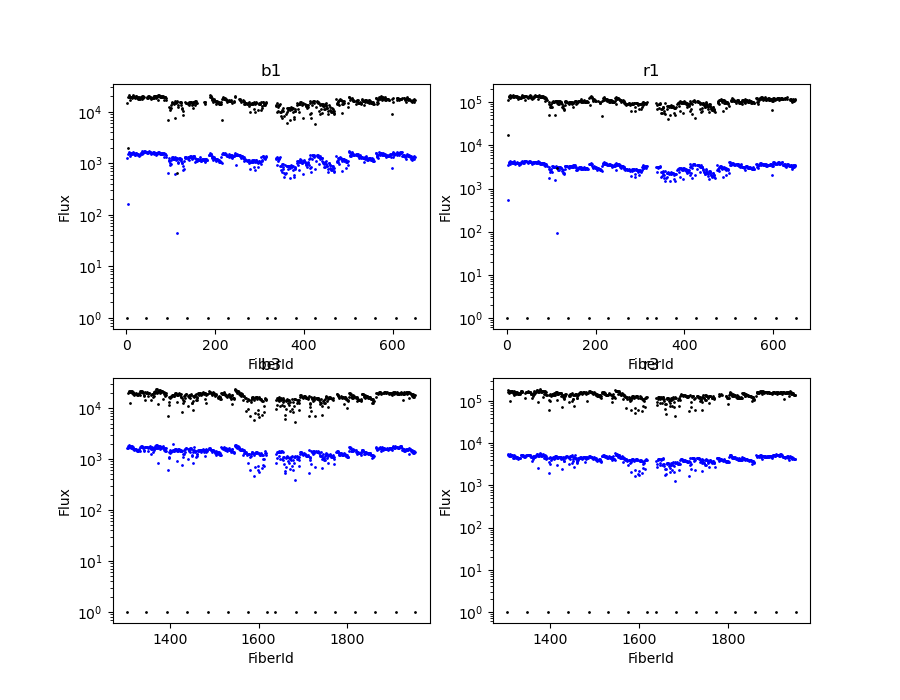

In [75]:
plt.close("all")

fig, axes = plt.subplots(2, 2)
for ax, spec, name in zip(axes.flatten(), (b1, r1, b3, r3), ("b1", "r1", "b3", "r3")):
    ax.scatter(spec.fiberId, np.median(spec.flux[:, 2000:2100], axis=1), s=1, color="b")
    ax.scatter(spec.fiberId, np.median(spec.norm[:, 2000:2100], axis=1), s=1, color="k")
    ax.set_xlabel("FiberId")
    ax.set_ylabel("Flux")
    ax.semilogy()
    ax.set_title(name)

That's the same pattern.

In [76]:
def plotFluxOnSky(pfsConfig, fiberId, flux, *, label="Flux", axes=None, cmap=None, norm=None):
    """Plot flux at the cobra position

    Parameters
    ----------
    pfsConfig : `pfs.datamodel.PfsConfig`
        Fiber configuration.
    fiberId : `numpy.ndarray` of `int`
        Fiber identifiers.
    flux : `numpy.ndarray` of `float`
        Flux values.
    label : `str`, optional
        Label for the colorbar.
    cmap : `matplotlib.colors.Colormap`, optional
        Colormap to use.
    norm : `matplotlib.colors.Normalize`, optional
        Normalization to use.

    Returns
    -------
    fig : `matplotlib.figure.Figure`
        Figure containing the plot.
    axes : `matplotlib.axes.Axes`
        Axes containing the plot.
    """
    from pfs.drp.stella.fitDistortedDetectorMap import addColorbar
    if axes is None:
        fig, axes = plt.subplots()
    else:
        fig = axes.figure
    if cmap is None:
        cmap = matplotlib.cm.rainbow
    if norm is None:
        good = np.isfinite(flux)
        norm = matplotlib.colors.Normalize()
        norm.autoscale(np.array(flux[good]))

    subConfig = pfsConfig.select(fiberId=fiberId)
    configIndices = np.argsort(subConfig.fiberId)
    fluxIndices = np.argsort(fiberId)
    if not np.all(subConfig.fiberId[configIndices] == fiberId[fluxIndices]):
        raise RuntimeError("Mismatch in fiberId")
    axes.scatter(
        subConfig.pfiNominal[:, 0][configIndices],
        subConfig.pfiNominal[:, 1][configIndices],
        c=cmap(norm(flux[fluxIndices])),
        marker="o",
    )
    axes.set_aspect("equal")
    addColorbar(fig, axes, cmap, norm, label)
    return fig, axes

Text(0.5, 0.98, 'visit=83263, r1+r3')

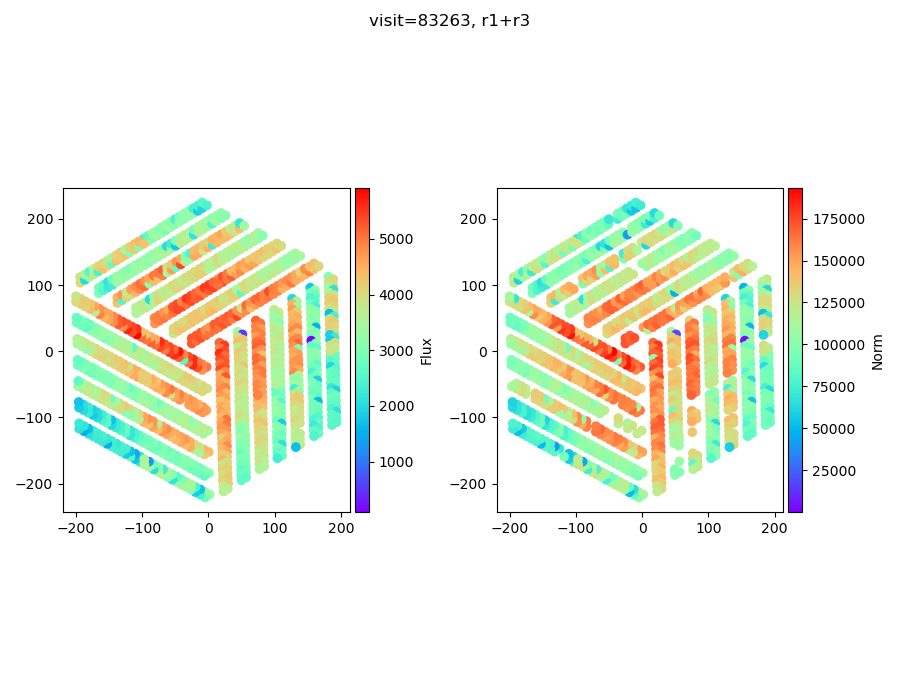

In [77]:
plt.close("all")
fiberId = np.concatenate((r1.fiberId, r3.fiberId))
flux = np.concatenate((
    np.median(r1.flux[:, 2000:2100], axis=1),
    np.median(r3.flux[:, 2000:2100], axis=1),
))
norm = np.concatenate((
    np.median(r1.norm[:, 2000:2100], axis=1),
    np.median(r3.norm[:, 2000:2100], axis=1),
))
fig, axes = plt.subplots(ncols=2)
plotFluxOnSky(pfsConfig, fiberId, flux, label="Flux", axes=axes[0])
plotFluxOnSky(pfsConfig, fiberId, norm, label="Norm", axes=axes[1])
plt.tight_layout()
fig.suptitle("visit=83263, r1+r3")


Text(0.5, 0.98, 'visit=83263')

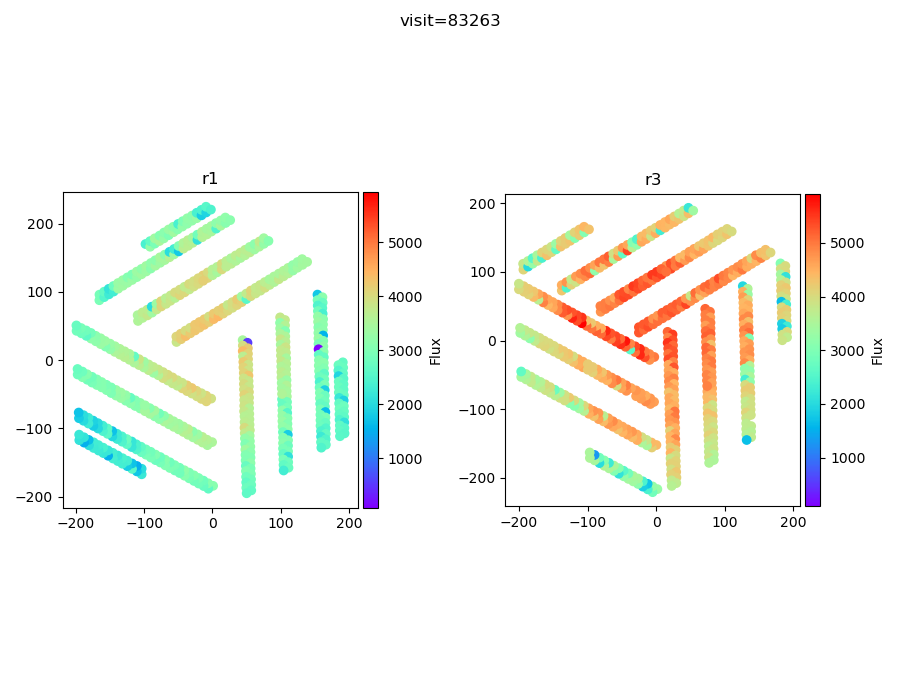

In [78]:
plt.close("all")
fig, axes = plt.subplots(ncols=2)
norm = matplotlib.colors.Normalize()
norm.autoscale(flux[np.isfinite(flux)])
plotFluxOnSky(pfsConfig, r1.fiberId, np.median(r1.flux[:, 2000:2100], axis=1), label="Flux", axes=axes[0], norm=norm)
plotFluxOnSky(pfsConfig, r3.fiberId, np.median(r3.flux[:, 2000:2100], axis=1), label="Flux", axes=axes[1], norm=norm)
plt.tight_layout()
axes[0].set_title("r1")
axes[1].set_title("r3")
fig.suptitle("visit=83263")

In [79]:
from pfs.drp.stella.utils.math import robustRms
flux1 = np.nanmedian((r1.flux/r1.norm)[:, 2000:2100], axis=1)
flux3 = np.nanmedian((r3.flux/r3.norm)[:, 2000:2100], axis=1)

print(np.nanmedian(flux1))
print(np.nanmedian(flux3))
print(robustRms(flux1[np.isfinite(flux1)])/np.nanmedian(flux1))
print(robustRms(flux3[np.isfinite(flux3)])/np.nanmedian(flux3))


0.029596094
0.030602291
0.08704765042246718
0.08047015196159586


Text(0.5, 0.98, 'visit=83263')

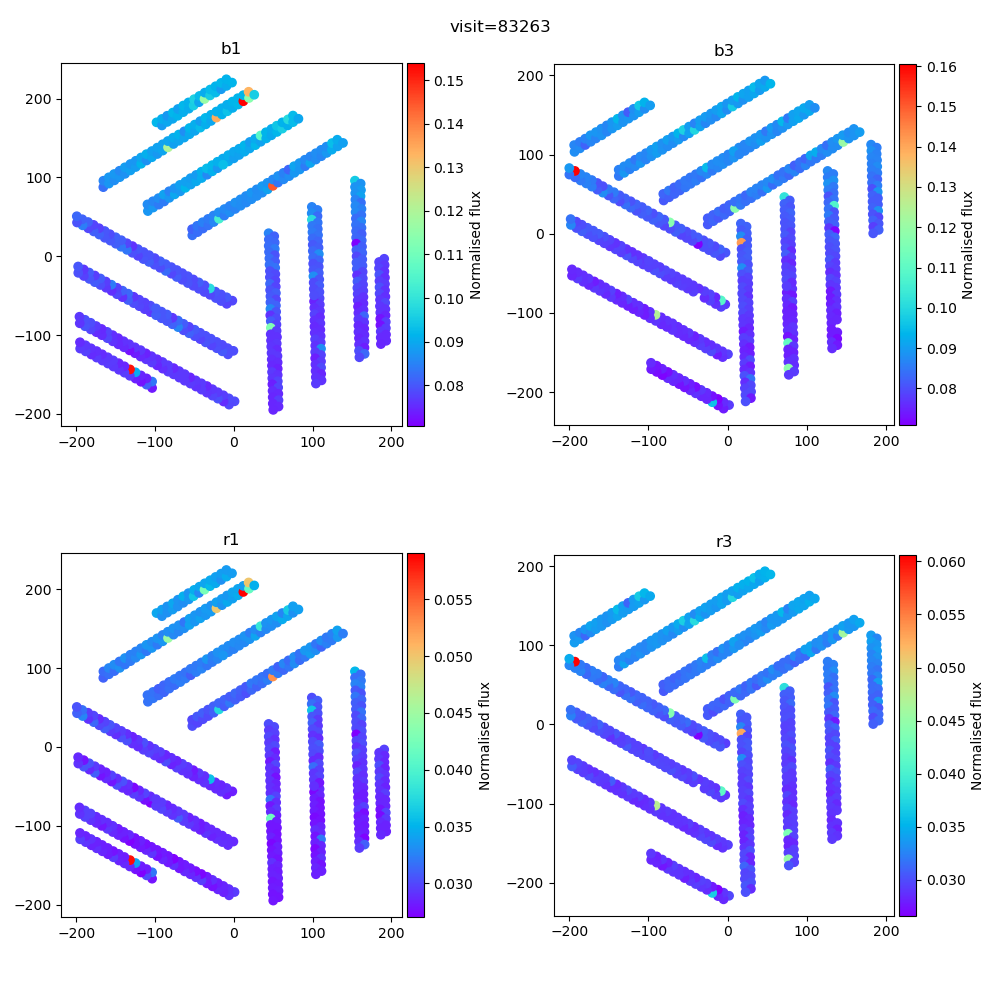

In [80]:
plt.close("all")
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plotFluxOnSky(pfsConfig, b1.fiberId, np.nanmedian((b1.flux/b1.norm)[:, 2000:2100], axis=1), label="Normalised flux", axes=axes[0][0])
plotFluxOnSky(pfsConfig, b3.fiberId, np.nanmedian((b3.flux/b3.norm)[:, 2000:2100], axis=1), label="Normalised flux", axes=axes[0][1])
plotFluxOnSky(pfsConfig, r1.fiberId, np.nanmedian((r1.flux/r1.norm)[:, 2000:2100], axis=1), label="Normalised flux", axes=axes[1][0])
plotFluxOnSky(pfsConfig, r3.fiberId, np.nanmedian((r3.flux/r3.norm)[:, 2000:2100], axis=1), label="Normalised flux", axes=axes[1][1])
plt.tight_layout()
axes[0][0].set_title("b1")
axes[0][1].set_title("b3")
axes[1][0].set_title("r1")
axes[1][1].set_title("r3")
fig.suptitle("visit=83263")

Text(0.5, 1.0, 'Red')

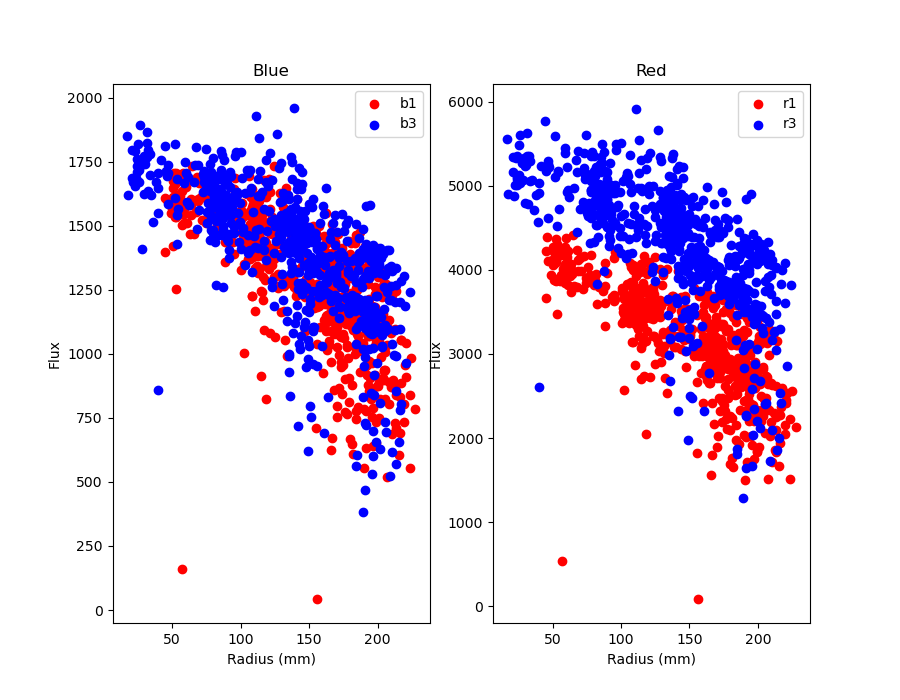

In [81]:
# Requested by Neven
plt.close("all")
fig, axes = plt.subplots(ncols=2)
radius = dict(zip(pfsConfig.fiberId, np.hypot(pfsConfig.pfiNominal[:, 0], pfsConfig.pfiNominal[:, 1])))
axes[0].scatter([radius[ff] for ff in b1.fiberId], np.nanmedian(b1.flux[:, 2000:2100], axis=1), color="r", marker="o", label="b1")
axes[0].scatter([radius[ff] for ff in b3.fiberId], np.nanmedian(b3.flux[:, 2000:2100], axis=1), color="b", marker="o", label="b3")
axes[1].scatter([radius[ff] for ff in r1.fiberId], np.nanmedian(r1.flux[:, 2000:2100], axis=1), color="r", marker="o", label="r1")
axes[1].scatter([radius[ff] for ff in r3.fiberId], np.nanmedian(r3.flux[:, 2000:2100], axis=1), color="b", marker="o", label="r3")
axes[0].legend()
axes[0].set_xlabel("Radius (mm)")
axes[0].set_ylabel("Flux")
axes[0].set_title("Blue")
axes[1].legend()
axes[1].set_xlabel("Radius (mm)")
axes[1].set_ylabel("Flux")
axes[1].set_title("Red")

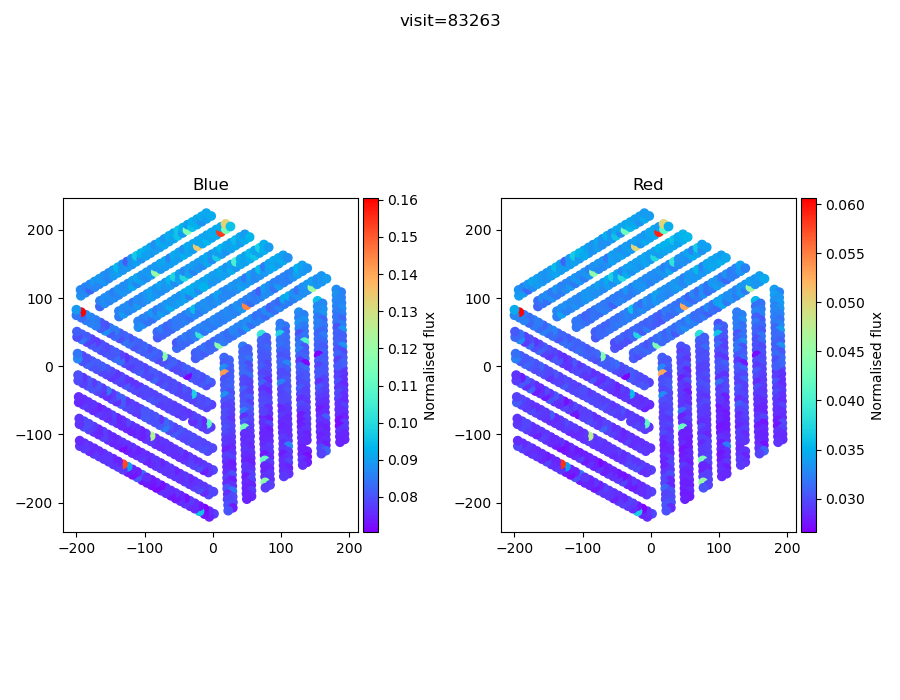

In [82]:
plt.close("all")
fig, axes = plt.subplots(ncols=2)
fiberId = np.concatenate((b1.fiberId, b3.fiberId))
blue = np.concatenate((
    np.nanmedian((b1.flux/b1.norm)[:, 2000:2100], axis=1),
    np.nanmedian((b3.flux/b3.norm)[:, 2000:2100], axis=1),
))
red = np.concatenate((
    np.nanmedian((r1.flux/r1.norm)[:, 2000:2100], axis=1),
    np.nanmedian((r3.flux/r3.norm)[:, 2000:2100], axis=1),
))
plotFluxOnSky(pfsConfig, fiberId, blue, label="Normalised flux", axes=axes[0])
plotFluxOnSky(pfsConfig, fiberId, red, label="Normalised flux", axes=axes[1])
axes[0].set_title("Blue")
axes[1].set_title("Red")
fig.suptitle("visit=83263")
fig.tight_layout()

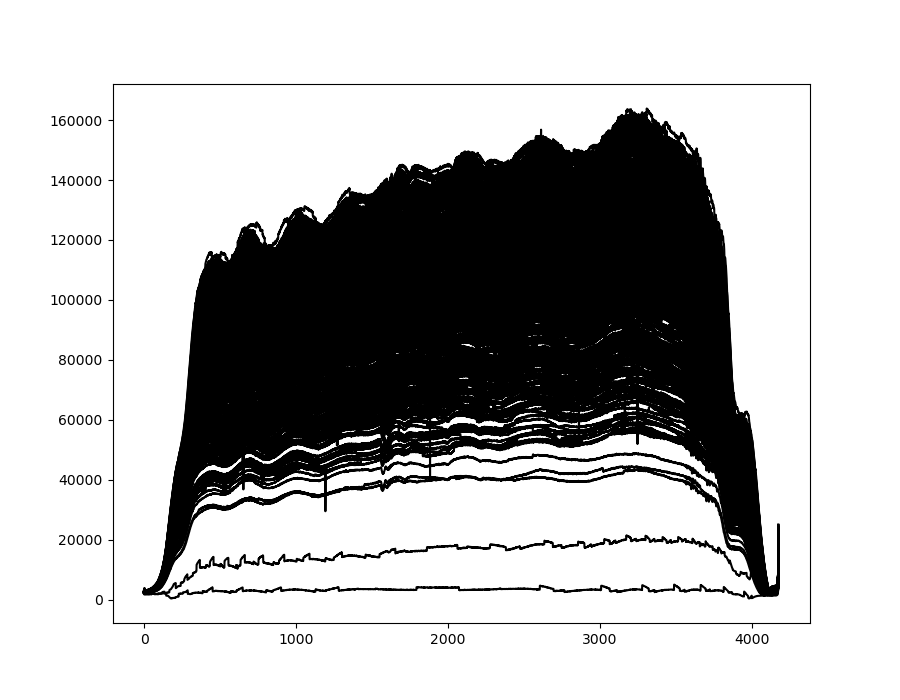

In [83]:
from pfs.drp.stella.fiberProfileSet import FiberProfileSet
profiles = FiberProfileSet.readFits("/work/drp/rerun/price/pipe2d-1133/FIBERPROFILES/pfsFiberProfiles-2022-11-15-082113-r1.fits")
plt.close("all")
for ff in profiles:
    plt.plot(profiles[ff].norm, "k-")

Text(0.5, 1.0, 'With old fiberProfiles')

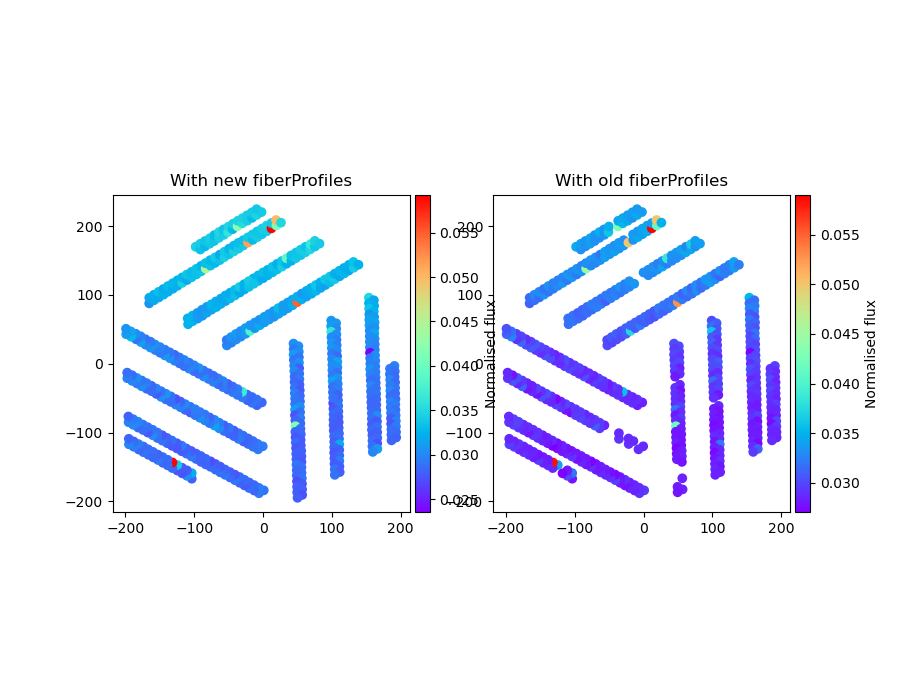

In [84]:
plt.close("all")
fig, axes = plt.subplots(ncols=2)
flux = np.array([np.median((r1.flux[ii]/profiles[ff].norm)[2000:2100]) if ff in profiles else np.nan for ii, ff in enumerate(r1.fiberId)])
plotFluxOnSky(pfsConfig, r1.fiberId, flux, label="Normalised flux", axes=axes[0])
plotFluxOnSky(pfsConfig, r1.fiberId, np.median((r1.flux/r1.norm)[:, 2000:2100], axis=1), label="Normalised flux", axes=axes[1])
axes[0].set_title("With new fiberProfiles")
axes[1].set_title("With old fiberProfiles")